<a href="https://colab.research.google.com/github/tnshq/ESRGAN/blob/main/correctesrgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from google.colab import drive
drive.mount('/content/drive')

# Setup Kaggle API
!mkdir -p ~/.kaggle/
!cp "/content/drive/MyDrive/kaggle/kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!python -m pip install -qq kaggle

print("✅ Google Drive mounted and Kaggle API configured!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted and Kaggle API configured!


In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Download DIV2K dataset from Kaggle
!kaggle datasets download -d joe1995/div2k-dataset

# Extract the dataset
!unzip -qq "div2k-dataset.zip"

# Check the extracted structure
import os
print("📁 Dataset structure:")
for dirname, _, filenames in os.walk('/content'):
    if 'DIV2K' in dirname or 'div2k' in dirname:
        print(f"📂 {dirname}")
        if filenames:
            print(f"   Files: {len(filenames)} items")


Dataset URL: https://www.kaggle.com/datasets/joe1995/div2k-dataset
License(s): unknown
User cancelled operation
replace DIV2K_train_HR/DIV2K_train_HR/0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
📁 Dataset structure:
📂 /content/DIV2K_train_HR
📂 /content/DIV2K_train_HR/DIV2K_train_HR
   Files: 800 items
📂 /content/DIV2K_valid_HR
📂 /content/DIV2K_valid_HR/DIV2K_valid_HR
   Files: 100 items


In [28]:
import os
import shutil

# Create organized dataset structure
project_path = '/content/ESRGAN_Project'
os.makedirs(f'{project_path}/dataset/train/hr', exist_ok=True)
os.makedirs(f'{project_path}/dataset/train/lr', exist_ok=True)
os.makedirs(f'{project_path}/dataset/valid/hr', exist_ok=True)
os.makedirs(f'{project_path}/dataset/valid/lr', exist_ok=True)
os.makedirs(f'{project_path}/models', exist_ok=True)
os.makedirs(f'{project_path}/results', exist_ok=True)

# Find DIV2K folders and organize
div2k_path = None
hr_source = None
lr_source = None

# Search for the actual image folders
print("🔍 Searching for DIV2K dataset...")
for root, dirs, files in os.walk('/content'):
    # Look for folders containing actual images
    for d in dirs:
        if 'DIV2K_train_HR' in d and not div2k_path:
            potential_hr = os.path.join(root, d)
            # Check if this folder contains image files (not just subdirectories)
            contents = os.listdir(potential_hr)
            image_files = [f for f in contents if f.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.isfile(os.path.join(potential_hr, f))]

            if image_files:
                hr_source = potential_hr
                print(f"✅ Found HR images folder: {hr_source}")
                break
            else:
                # Check if there's a nested folder with the same name
                nested_hr = os.path.join(potential_hr, 'DIV2K_train_HR')
                if os.path.exists(nested_hr):
                    nested_contents = os.listdir(nested_hr)
                    nested_images = [f for f in nested_contents if f.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.isfile(os.path.join(nested_hr, f))]
                    if nested_images:
                        hr_source = nested_hr
                        print(f"✅ Found HR images in nested folder: {hr_source}")
                        break

# Search for LR folder
for root, dirs, files in os.walk('/content'):
    for d in dirs:
        if 'DIV2K_train_LR' in d:
            potential_lr_root = os.path.join(root, d)
            # Look for X4 subfolder
            x4_folder = os.path.join(potential_lr_root, 'X4')
            if os.path.exists(x4_folder):
                lr_source = x4_folder
                print(f"✅ Found LR images folder: {lr_source}")
                break
            # Check for nested structure
            elif os.path.exists(os.path.join(potential_lr_root, 'DIV2K_train_LR_bicubic', 'X4')):
                lr_source = os.path.join(potential_lr_root, 'DIV2K_train_LR_bicubic', 'X4')
                print(f"✅ Found LR images in nested folder: {lr_source}")
                break

if hr_source and os.path.exists(hr_source):
    # Get only image files, not directories
    hr_items = os.listdir(hr_source)
    hr_files = [f for f in hr_items if f.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.isfile(os.path.join(hr_source, f))]

    print(f"📸 Found {len(hr_files)} HR training images")

    if hr_files:
        # Copy first 700 images for training, rest for validation
        train_count = min(700, len(hr_files))

        print(f"📁 Copying {train_count} images for training...")
        for i, file in enumerate(hr_files[:train_count]):
            src_path = os.path.join(hr_source, file)
            dst_path = os.path.join(f'{project_path}/dataset/train/hr/', file)

            # Double-check it's actually a file before copying
            if os.path.isfile(src_path):
                shutil.copy2(src_path, dst_path)
            else:
                print(f"⚠️ Skipping {file} - not a file")

        # Copy remaining for validation
        if len(hr_files) > train_count:
            val_files = hr_files[train_count:]
            print(f"📁 Copying {len(val_files)} images for validation...")
            for file in val_files:
                src_path = os.path.join(hr_source, file)
                dst_path = os.path.join(f'{project_path}/dataset/valid/hr/', file)

                if os.path.isfile(src_path):
                    shutil.copy2(src_path, dst_path)

    # Handle LR images if they exist
    if lr_source and os.path.exists(lr_source):
        lr_items = os.listdir(lr_source)
        lr_files = [f for f in lr_items if f.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.isfile(os.path.join(lr_source, f))]

        print(f"📸 Found {len(lr_files)} LR training images")

        # Copy corresponding LR images
        train_count = min(700, len(lr_files))
        for file in lr_files[:train_count]:
            src_path = os.path.join(lr_source, file)
            dst_path = os.path.join(f'{project_path}/dataset/train/lr/', file)

            if os.path.isfile(src_path):
                shutil.copy2(src_path, dst_path)

        # Copy remaining for validation
        if len(lr_files) > train_count:
            for file in lr_files[train_count:]:
                src_path = os.path.join(lr_source, file)
                dst_path = os.path.join(f'{project_path}/dataset/valid/lr/', file)

                if os.path.isfile(src_path):
                    shutil.copy2(src_path, dst_path)
    else:
        print("ℹ️ No LR images found - will generate them from HR images during training")

else:
    print("❌ DIV2K dataset folders not found!")

print("\n📁 Final dataset structure:")
print(f"Training HR: {len(os.listdir(f'{project_path}/dataset/train/hr'))} images")
print(f"Training LR: {len(os.listdir(f'{project_path}/dataset/train/lr'))} images")
print(f"Validation HR: {len(os.listdir(f'{project_path}/dataset/valid/hr'))} images")
print(f"Validation LR: {len(os.listdir(f'{project_path}/dataset/valid/lr'))} images")


🔍 Searching for DIV2K dataset...
✅ Found HR images in nested folder: /content/DIV2K_train_HR/DIV2K_train_HR
✅ Found HR images folder: /content/DIV2K_train_HR/DIV2K_train_HR
📸 Found 800 HR training images
📁 Copying 700 images for training...
📁 Copying 100 images for validation...
ℹ️ No LR images found - will generate them from HR images during training

📁 Final dataset structure:
Training HR: 700 images
Training LR: 0 images
Validation HR: 100 images
Validation LR: 0 images


In [29]:
!pip install -q torch torchvision torchaudio
!pip install -q opencv-python pillow matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision.utils import save_image
import torch.nn.functional as F
import random
from pathlib import Path

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


✅ All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [30]:
# Model save/load configuration
MODEL_SAVE_PATH = f"{project_path}/models/esrgan_generator.pth"
CHECKPOINT_PATH = f"{project_path}/models/esrgan_checkpoint.pth"

def save_model(generator, discriminator, optimizer_gen, optimizer_disc, epoch, loss):
    """Save model weights and training state"""
    checkpoint = {
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_gen_state_dict': optimizer_gen.state_dict(),
        'optimizer_disc_state_dict': optimizer_disc.state_dict(),
        'epoch': epoch,
        'loss': loss
    }

    # Save complete checkpoint
    torch.save(checkpoint, CHECKPOINT_PATH)

    # Save just generator for inference
    torch.save(generator.state_dict(), MODEL_SAVE_PATH)

    print(f"💾 Model saved! Generator: {MODEL_SAVE_PATH}")

def load_model_for_inference(generator, device):
    """Load generator weights for inference only"""
    if os.path.exists(MODEL_SAVE_PATH):
        generator.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        generator.eval()
        print(f"✅ Generator loaded from {MODEL_SAVE_PATH}")
        return True
    else:
        print(f"❌ No saved model found at {MODEL_SAVE_PATH}")
        return False

def load_checkpoint(generator, discriminator, optimizer_gen, optimizer_disc, device):
    """Load complete training checkpoint to resume training"""
    if os.path.exists(CHECKPOINT_PATH):
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        optimizer_gen.load_state_dict(checkpoint['optimizer_gen_state_dict'])
        optimizer_disc.load_state_dict(checkpoint['optimizer_disc_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"✅ Checkpoint loaded! Resuming from epoch {start_epoch}")
        return start_epoch
    else:
        print("ℹ️ No checkpoint found, starting fresh training")
        return 0

def check_trained_model_exists():
    """Check if a trained model already exists"""
    return os.path.exists(MODEL_SAVE_PATH)

print("✅ Save/Load functions defined!")


✅ Save/Load functions defined!


In [31]:
class ResidualDenseBlock(nn.Module):
    def __init__(self, num_feat=64, num_grow_ch=32):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_feat, num_grow_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(num_feat + num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv3 = nn.Conv2d(num_feat + 2 * num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv4 = nn.Conv2d(num_feat + 3 * num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv5 = nn.Conv2d(num_feat + 4 * num_grow_ch, num_feat, 3, 1, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x

print("✅ ResidualDenseBlock defined!")


✅ ResidualDenseBlock defined!


In [32]:
class RRDB(nn.Module):
    def __init__(self, num_feat, num_grow_ch=32):
        super(RRDB, self).__init__()
        self.rdb1 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb2 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb3 = ResidualDenseBlock(num_feat, num_grow_ch)

    def forward(self, x):
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        return out * 0.2 + x

print("✅ RRDB Block defined!")


✅ RRDB Block defined!


In [33]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super(Generator, self).__init__()

        # First layer
        self.conv1 = nn.Conv2d(in_channels, num_channels, kernel_size=3, stride=1, padding=1)

        # RRDB blocks
        self.trunk = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])

        # Second conv layer post residual blocks
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)

        # Upsampling layers
        self.upconv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.upconv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)

        # Final output layer
        self.conv3 = nn.Conv2d(num_channels, in_channels, kernel_size=3, stride=1, padding=1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.conv1(x)
        trunk = self.trunk(fea)
        fea = self.conv2(trunk) + fea

        # Upsampling
        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))

        out = self.conv3(fea)
        return torch.tanh(out)

print("✅ Generator model defined!")


✅ Generator model defined!


In [34]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, 2, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Conv2d(512, 1, 4, 1, 1)
        )

    def forward(self, img):
        return self.model(img)

print("✅ Discriminator model defined!")


✅ Discriminator model defined!


In [35]:
class DIV2KDataset(Dataset):
    def __init__(self, hr_folder, lr_folder, transform=None, crop_size=128):
        self.hr_folder = hr_folder
        self.lr_folder = lr_folder
        self.transform = transform
        self.crop_size = crop_size

        # Get all image files
        self.hr_images = [f for f in os.listdir(hr_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"📸 Found {len(self.hr_images)} training images")

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr_filename = self.hr_images[idx]

        # Create corresponding LR filename
        lr_filename = hr_filename.replace('.png', 'x4.png')

        hr_path = os.path.join(self.hr_folder, hr_filename)
        lr_path = os.path.join(self.lr_folder, lr_filename)

        # Load images
        hr_image = Image.open(hr_path).convert('RGB')

        # If LR doesn't exist, create it by downsampling HR
        if not os.path.exists(lr_path):
            lr_image = hr_image.resize((hr_image.width//4, hr_image.height//4), Image.BICUBIC)
        else:
            lr_image = Image.open(lr_path).convert('RGB')

        # Random crop for training
        if self.crop_size:
            # Get random crop coordinates
            hr_width, hr_height = hr_image.size
            lr_width, lr_height = lr_image.size

            if hr_width >= self.crop_size and hr_height >= self.crop_size:
                left = random.randint(0, hr_width - self.crop_size)
                top = random.randint(0, hr_height - self.crop_size)

                hr_image = hr_image.crop((left, top, left + self.crop_size, top + self.crop_size))

                # Corresponding LR crop
                lr_left = left // 4
                lr_top = top // 4
                lr_crop_size = self.crop_size // 4
                lr_image = lr_image.crop((lr_left, lr_top, lr_left + lr_crop_size, lr_top + lr_crop_size))

        if self.transform:
            hr_image = self.transform(hr_image)
            lr_image = self.transform(lr_image)

        return lr_image, hr_image

print("✅ DIV2K Dataset class defined!")


✅ DIV2K Dataset class defined!


In [36]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Dataset paths
train_hr_path = f'{project_path}/dataset/train/hr'
train_lr_path = f'{project_path}/dataset/train/lr'

# Check dataset
hr_count = len([f for f in os.listdir(train_hr_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
print(f"📊 Training images: {hr_count}")

if hr_count == 0:
    print("❌ No training images found!")
else:
    print("✅ Dataset ready for training!")

# Check if model already exists
if check_trained_model_exists():
    choice = input("🔍 Trained model found! Do you want to:\n1. Use existing model (skip training)\n2. Retrain from scratch\nEnter choice (1 or 2): ")

    if choice == '1':
        print("⏭️ Skipping training, using existing model...")
        skip_training = True
    else:
        print("🔄 Starting fresh training...")
        skip_training = False
else:
    print("🆕 No existing model found, starting training...")
    skip_training = False

# Initialize models
generator = Generator(in_channels=3, num_channels=64, num_blocks=23).to(device)
discriminator = Discriminator(in_channels=3).to(device)

# Loss functions
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_pixelwise = nn.L1Loss()

# Optimizers
optimizer_gen = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.9, 0.999))
optimizer_disc = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.9, 0.999))

print("✅ Models and optimizers initialized!")


🚀 Using device: cuda
📊 Training images: 700
✅ Dataset ready for training!
🔍 Trained model found! Do you want to:
1. Use existing model (skip training)
2. Retrain from scratch
Enter choice (1 or 2): 1
⏭️ Skipping training, using existing model...
✅ Models and optimizers initialized!


In [37]:
# Only proceed with training if not skipping
if not skip_training and hr_count > 0:
    # Training parameters
    num_epochs = 50  # Adjust based on your needs
    batch_size = 4   # Reduce if you get memory errors
    crop_size = 128  # Training crop size

    print(f"🏋️ Starting training with:")
    print(f"   Epochs: {num_epochs}")
    print(f"   Batch size: {batch_size}")
    print(f"   Crop size: {crop_size}")

    # Data transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Create dataset and dataloader
    dataset = DIV2KDataset(train_hr_path, train_lr_path, transform, crop_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    print(f"📚 Dataset: {len(dataset)} images, {len(dataloader)} batches per epoch")

    # Training loop
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()

        epoch_gen_loss = 0
        epoch_disc_loss = 0
        batch_count = 0

        for i, (lr_imgs, hr_imgs) in enumerate(dataloader):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            # Train Generator
            optimizer_gen.zero_grad()

            gen_hr = generator(lr_imgs)

            # Adversarial loss
            pred_real = discriminator(hr_imgs).detach()
            pred_fake = discriminator(gen_hr)

            loss_GAN = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True),
                                    torch.ones_like(pred_fake))

            # Pixel-wise loss
            loss_pixel = criterion_pixelwise(gen_hr, hr_imgs)

            # Total generator loss
            loss_gen = loss_GAN + 100 * loss_pixel

            loss_gen.backward()
            optimizer_gen.step()

            # Train Discriminator
            optimizer_disc.zero_grad()

            pred_real = discriminator(hr_imgs)
            pred_fake = discriminator(gen_hr.detach())

            loss_real = criterion_GAN(pred_real - pred_fake.mean(0, keepdim=True),
                                     torch.ones_like(pred_real))
            loss_fake = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True),
                                     torch.zeros_like(pred_fake))

            loss_disc = (loss_real + loss_fake) / 2

            loss_disc.backward()
            optimizer_disc.step()

            epoch_gen_loss += loss_gen.item()
            epoch_disc_loss += loss_disc.item()
            batch_count += 1

            # Print batch progress
            if i % 50 == 0:
                print(f"   Batch {i}/{len(dataloader)}, Gen: {loss_gen.item():.4f}, Disc: {loss_disc.item():.4f}")

        # Print epoch progress
        avg_gen_loss = epoch_gen_loss / batch_count
        avg_disc_loss = epoch_disc_loss / batch_count

        print(f"🔥 Epoch [{epoch+1}/{num_epochs}] - Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}")

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            save_model(generator, discriminator, optimizer_gen, optimizer_disc, epoch, avg_gen_loss)
            print(f"💾 Checkpoint saved at epoch {epoch+1}")

    # Save the final model
    save_model(generator, discriminator, optimizer_gen, optimizer_disc, epoch, avg_gen_loss)
    print("🎉 Training completed and model saved!")

elif skip_training:
    print("⏭️ Training skipped. Loading existing model...")
else:
    print("❌ Cannot start training - no dataset found!")


⏭️ Training skipped. Loading existing model...


In [38]:
def inference_single_image(image_path, output_path=None):
    """Perform super-resolution on a single image"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize generator
    generator = Generator(in_channels=3, num_channels=64, num_blocks=23).to(device)

    # Load trained model
    if not load_model_for_inference(generator, device):
        return None

    # Load and preprocess image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load image
    img = Image.open(image_path).convert('RGB')
    original_size = img.size

    # Ensure dimensions are divisible by 4 for proper upsampling
    new_width = (img.width // 4) * 4
    new_height = (img.height // 4) * 4
    img = img.resize((new_width, new_height), Image.LANCZOS)

    img_tensor = transform(img).unsqueeze(0).to(device)

    # Generate high-resolution image
    with torch.no_grad():
        hr_img = generator(img_tensor)

    # Convert back to PIL Image
    hr_img = hr_img.squeeze(0).cpu()
    hr_img = (hr_img + 1) / 2  # Denormalize
    hr_img = torch.clamp(hr_img, 0, 1)
    hr_img = transforms.ToPILImage()(hr_img)

    # Save or return result
    if output_path:
        hr_img.save(output_path)
        print(f"💾 Super-resolution image saved to {output_path}")

    return hr_img, img

def display_comparison(lr_image, hr_image):
    """Display comparison between low-res and super-res images"""
    plt.figure(figsize=(15, 7))

    # Low resolution image
    plt.subplot(1, 2, 1)
    plt.imshow(lr_image)
    plt.title(f'Input Image\nSize: {lr_image.size}')
    plt.axis('off')

    # Super resolution image
    plt.subplot(1, 2, 2)
    plt.imshow(hr_image)
    plt.title(f'Super-Resolution (4x)\nSize: {hr_image.size}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

print("✅ Inference functions defined!")


✅ Inference functions defined!


🧪 Testing the trained model...
🔍 Testing with: 0570.png
✅ Generator loaded from /content/ESRGAN_Project/models/esrgan_generator.pth
💾 Super-resolution image saved to /content/ESRGAN_Project/results/test_super_res.png
✅ Super-resolution successful!


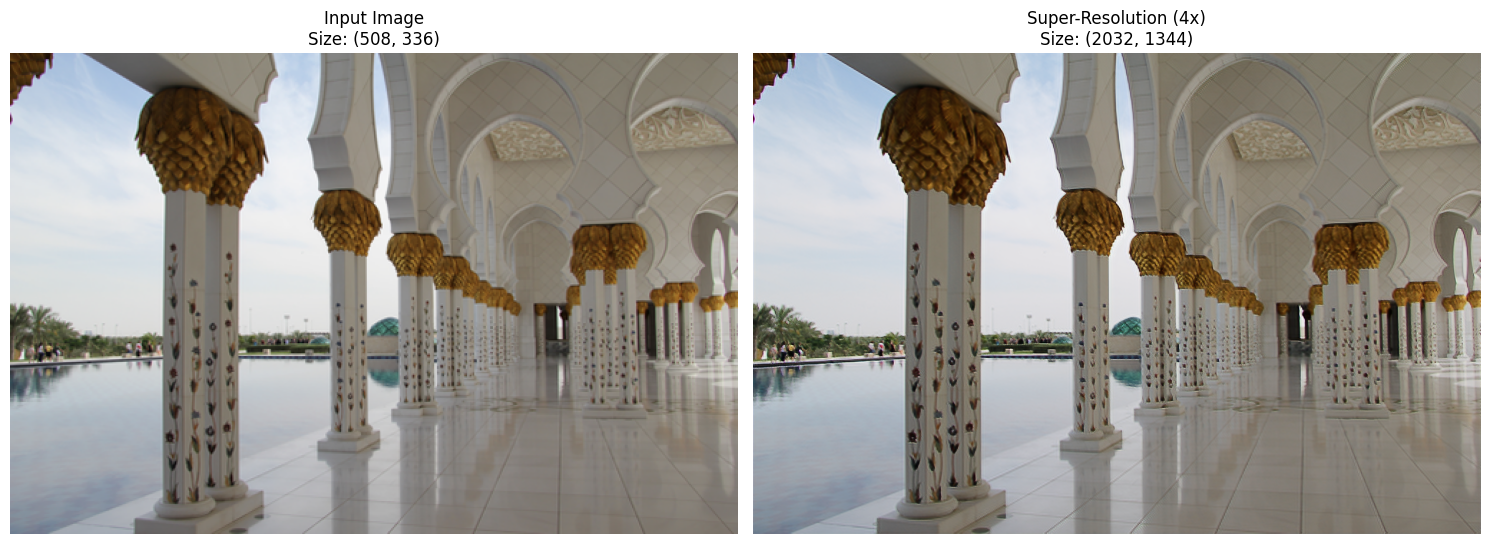

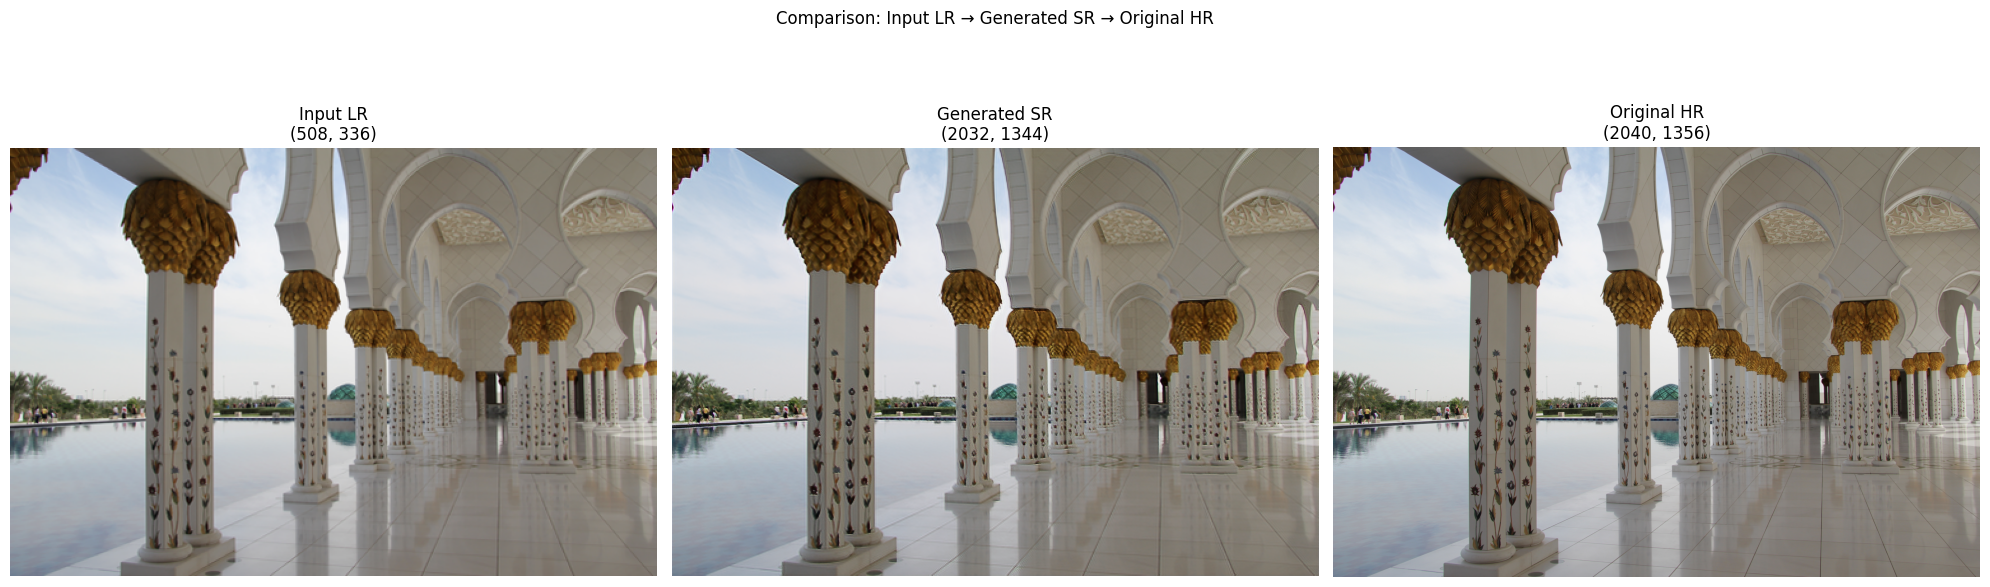

In [39]:
# Test the trained model
print("🧪 Testing the trained model...")

# Load a sample image from validation set for testing
valid_hr_path = f'{project_path}/dataset/valid/hr'
valid_images = [f for f in os.listdir(valid_hr_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if valid_images and check_trained_model_exists():
    # Test with first validation image
    test_image_path = os.path.join(valid_hr_path, valid_images[0])
    output_path = f"{project_path}/results/test_super_res.png"

    print(f"🔍 Testing with: {valid_images[0]}")

    # Create a low-res version for testing
    test_hr = Image.open(test_image_path).convert('RGB')
    test_lr = test_hr.resize((test_hr.width//4, test_hr.height//4), Image.BICUBIC)
    test_lr_path = f"{project_path}/results/test_input.png"
    test_lr.save(test_lr_path)

    # Perform super-resolution
    result_hr, input_lr = inference_single_image(test_lr_path, output_path)

    if result_hr:
        print("✅ Super-resolution successful!")
        display_comparison(input_lr, result_hr)

        # Also show the original HR for comparison
        plt.figure(figsize=(20, 7))

        plt.subplot(1, 3, 1)
        plt.imshow(input_lr)
        plt.title(f'Input LR\n{input_lr.size}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(result_hr)
        plt.title(f'Generated SR\n{result_hr.size}')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(test_hr)
        plt.title(f'Original HR\n{test_hr.size}')
        plt.axis('off')

        plt.suptitle('Comparison: Input LR → Generated SR → Original HR')
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Super-resolution failed!")

elif not check_trained_model_exists():
    print("❌ No trained model found! Please train the model first.")
else:
    print("❌ No validation images found for testing!")


In [40]:
from google.colab import files

def upload_and_test():
    """Upload your own image and test super-resolution"""
    print("📤 Upload an image to test super-resolution:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"🔍 Processing: {filename}")

        # Perform super-resolution
        output_filename = f"super_res_{filename}"
        output_path = f"{project_path}/results/{output_filename}"

        result_hr, input_img = inference_single_image(filename, output_path)

        if result_hr:
            print("✅ Success!")
            display_comparison(input_img, result_hr)

            # Download the result
            files.download(output_path)
        else:
            print("❌ Failed to process image!")

# Uncomment to test with your own image:
# upload_and_test()

print("✅ Upload and test function ready!")
print("📝 Run upload_and_test() to test with your own images")


✅ Upload and test function ready!
📝 Run upload_and_test() to test with your own images


📤 Upload an image to test super-resolution:


Saving download-2.jpg to download-2.jpg
🔍 Processing: download-2.jpg
✅ Generator loaded from /content/ESRGAN_Project/models/esrgan_generator.pth
💾 Super-resolution image saved to /content/ESRGAN_Project/results/super_res_download-2.jpg
✅ Success!


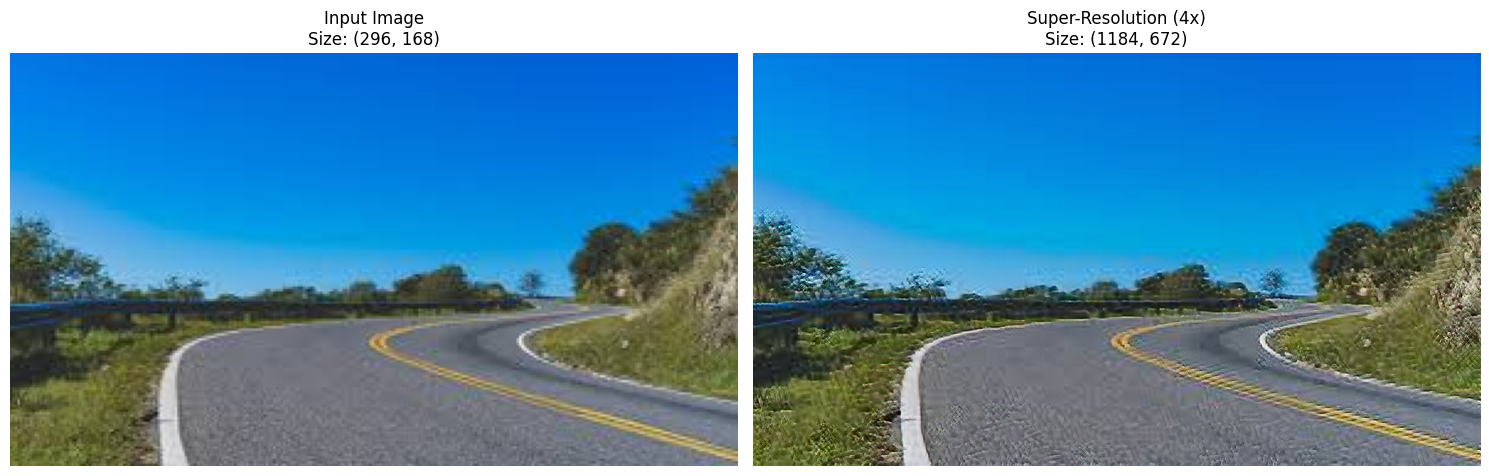

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
upload_and_test()

📤 Upload an image to test super-resolution:


Saving download-3.jpg to download-3.jpg
🔍 Processing: download-3.jpg
✅ Generator loaded from /content/ESRGAN_Project/models/esrgan_generator.pth
💾 Super-resolution image saved to /content/ESRGAN_Project/results/super_res_download-3.jpg
✅ Success!


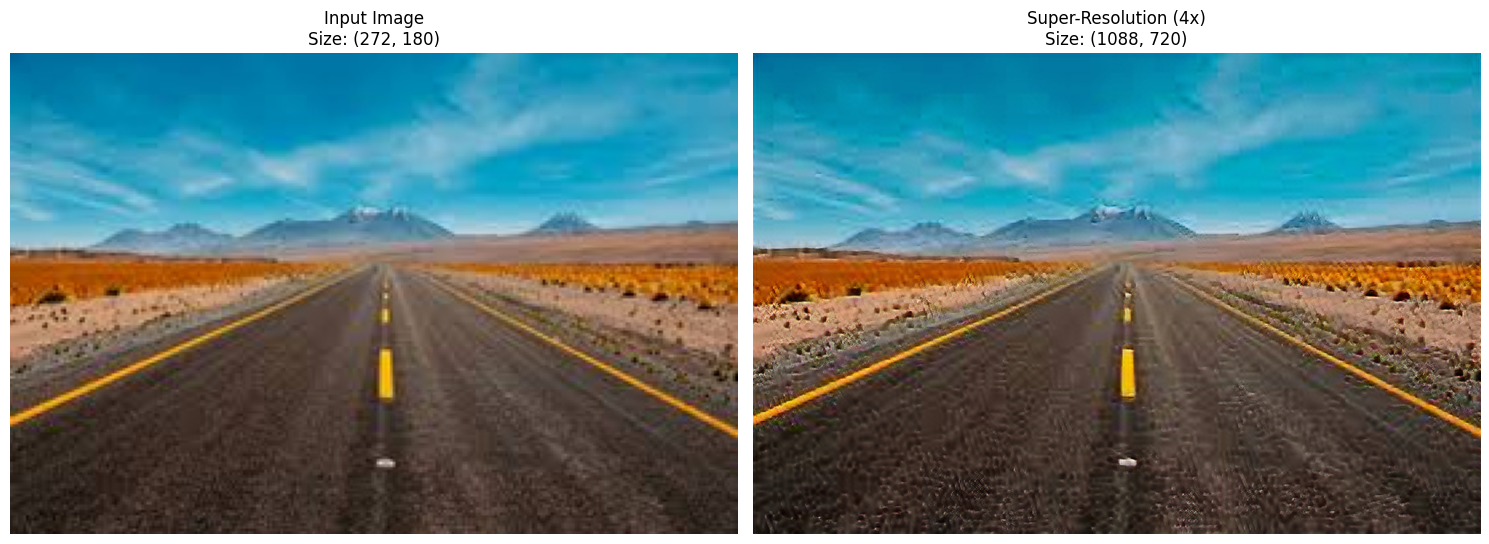

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
upload_and_test()


In [47]:
# Install clean-fid
!pip install git+https://github.com/GaParmar/clean-fid.git

# Imports
from cleanfid import fid
import os
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
import math

# Define paths
valid_hr_path = f'{project_path}/dataset/valid/hr'
valid_lr_path = f'{project_path}/dataset/valid/lr'  # LR images exist or will be generated
generated_sr_path = f'{project_path}/results/fid_generated_sr'
os.makedirs(generated_sr_path, exist_ok=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize and load generator model
generator = Generator(in_channels=3, num_channels=64, num_blocks=23).to(device)
if not load_model_for_inference(generator, device):
    print("❌ Could not load generator model. Cannot calculate metrics.")
else:
    print("✅ Generator loaded for metric calculation.")
    generator.eval()  # Set generator to evaluation mode

    # Data transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Get validation HR images
    valid_hr_images = [f for f in os.listdir(valid_hr_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Generating SR images and calculating metrics for {len(valid_hr_images)} images...")

    # Metric lists
    psnr_scores = []
    ssim_scores = []

    # PSNR function
    def calculate_psnr(sr, hr, max_pixel=1.0):
        mse = torch.mean((sr - hr) ** 2)
        if mse == 0:
            return float('inf')
        return 20 * torch.log10(torch.tensor(max_pixel)) - 10 * torch.log10(mse)

    # SSIM function
    def calculate_ssim(sr_pil, hr_pil):
        sr_np = np.array(sr_pil)
        hr_np = np.array(hr_pil)
        if sr_np.ndim == 3 and sr_np.shape[2] == 3:  # RGB to grayscale
            sr_np_gray = np.dot(sr_np[...,:3], [0.299, 0.587, 0.114])
            hr_np_gray = np.dot(hr_np[...,:3], [0.299, 0.587, 0.114])
        else:
            sr_np_gray = sr_np
            hr_np_gray = hr_np
        return ssim(sr_np_gray, hr_np_gray, data_range=hr_np_gray.max() - hr_np_gray.min())

    # Generate SR images and calculate metrics
    with torch.no_grad():
        for img_name in valid_hr_images:
            hr_img_path = os.path.join(valid_hr_path, img_name)
            lr_img_path = os.path.join(valid_lr_path, img_name.replace('.png', 'x4.png'))

            try:
                hr_img_pil = Image.open(hr_img_path).convert('RGB')

                # Use LR if exists, else downsample HR
                if os.path.exists(lr_img_path):
                    lr_img_pil = Image.open(lr_img_path).convert('RGB')
                else:
                    lr_img_pil = hr_img_pil.resize((hr_img_pil.width//4, hr_img_pil.height//4), Image.BICUBIC)

                # Preprocess and generate SR
                lr_img_tensor = transform(lr_img_pil).unsqueeze(0).to(device)
                sr_img_tensor = generator(lr_img_tensor)

                # Convert back to PIL for saving and FID
                sr_img_tensor_display = sr_img_tensor.squeeze(0).cpu()
                sr_img_tensor_display = (sr_img_tensor_display + 1) / 2
                sr_img_tensor_display = torch.clamp(sr_img_tensor_display, 0, 1)
                sr_img_pil = transforms.ToPILImage()(sr_img_tensor_display)
                output_sr_path = os.path.join(generated_sr_path, img_name)
                sr_img_pil.save(output_sr_path)

                # Metrics
                hr_img_tensor = ToTensor()(hr_img_pil)
                sr_img_tensor_metrics = transforms.ToTensor()(sr_img_pil)
                psnr_score = calculate_psnr(sr_img_tensor_metrics, hr_img_tensor)
                ssim_score = calculate_ssim(sr_img_pil, hr_img_pil)

                psnr_scores.append(psnr_score)
                ssim_scores.append(ssim_score)

                # Print per-image metrics
                print(f"{img_name}: PSNR = {psnr_score:.4f}, SSIM = {ssim_score:.4f}")

            except Exception as e:
                print(f"Error processing {img_name}: {e}")
                continue

    print("✅ Finished generating SR images and calculating per-image metrics.")

    # Average metrics
    avg_psnr = np.mean(psnr_scores) if psnr_scores else 0
    avg_ssim = np.mean(ssim_scores) if ssim_scores else 0
    print("\n📊 Average Performance Metrics:")
    print(f"  Average PSNR: {avg_psnr:.4f}")
    print(f"  Average SSIM: {avg_ssim:.4f}")

    # FID calculation
    print("\nCalculating FID...")
    fid_score = fid.compute_fid(valid_hr_path, generated_sr_path, mode="clean", device=str(device))
    print(f"  FID Score: {fid_score:.4f}")


  Cloning https://github.com/GaParmar/clean-fid.git to /tmp/pip-req-build-zi40d7bp
  Running command git clone --filter=blob:none --quiet https://github.com/GaParmar/clean-fid.git /tmp/pip-req-build-zi40d7bp
  Resolved https://github.com/GaParmar/clean-fid.git to commit e88c4d6269a4bbf04c04deeb578475b57719acee
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-1sk1zaf8/clip_e456a6b137854164917de98fd48e149a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-1sk1zaf8/clip_e456a6b137854164917de98fd48e149a
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
✅ Generator loaded from /content/ESRGAN_Project/models/esrgan_generator.pth
✅ Generator loaded for metric calculation.
Generating SR images and calculating metrics for 100 images...
0570.png: PSNR = 25.1133, SSIM = 0.7726
0367.png: PSNR = 22.6

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 100 images in the folder /content/ESRGAN_Project/dataset/valid/hr


FID hr : 100%|██████████| 4/4 [00:19<00:00,  5.00s/it]


Found 100 images in the folder /content/ESRGAN_Project/results/fid_generated_sr


FID fid_generated_sr : 100%|██████████| 4/4 [00:19<00:00,  4.88s/it]


  FID Score: 9.0354
